In [1]:
import numpy as np
from PIL import Image, ImageDraw
import glob, os, shutil,sys
import csv as csv
from sklearn.utils import shuffle
from parsing import *
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

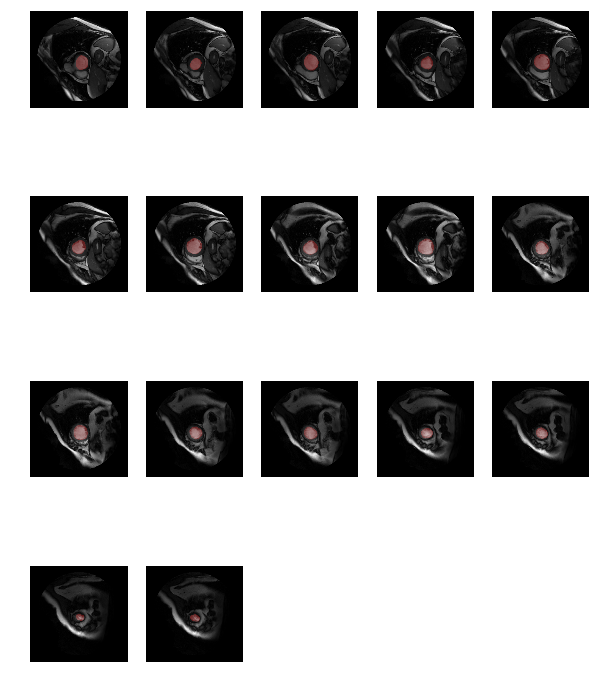

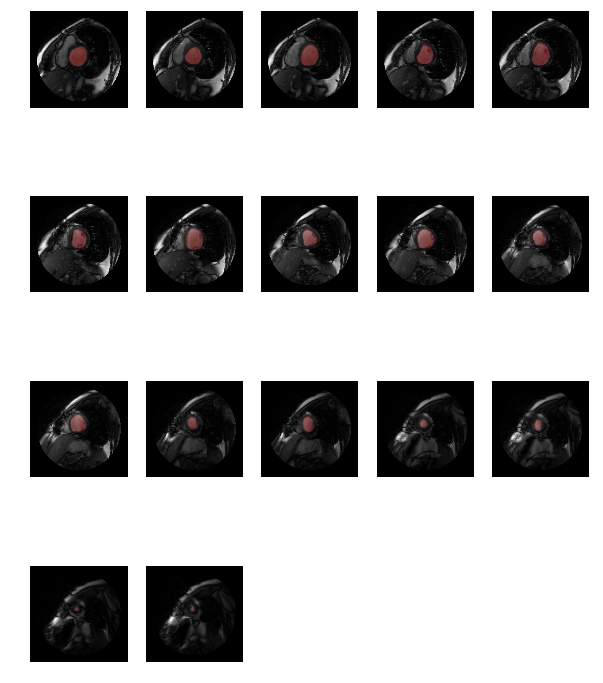

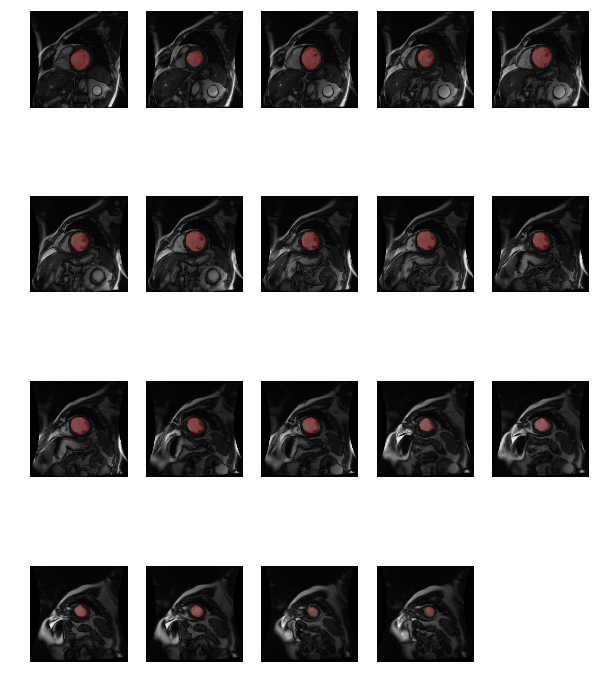

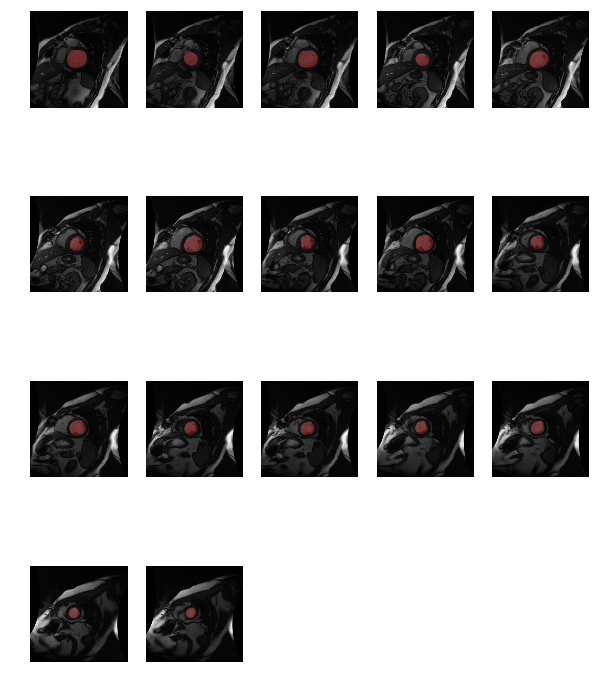

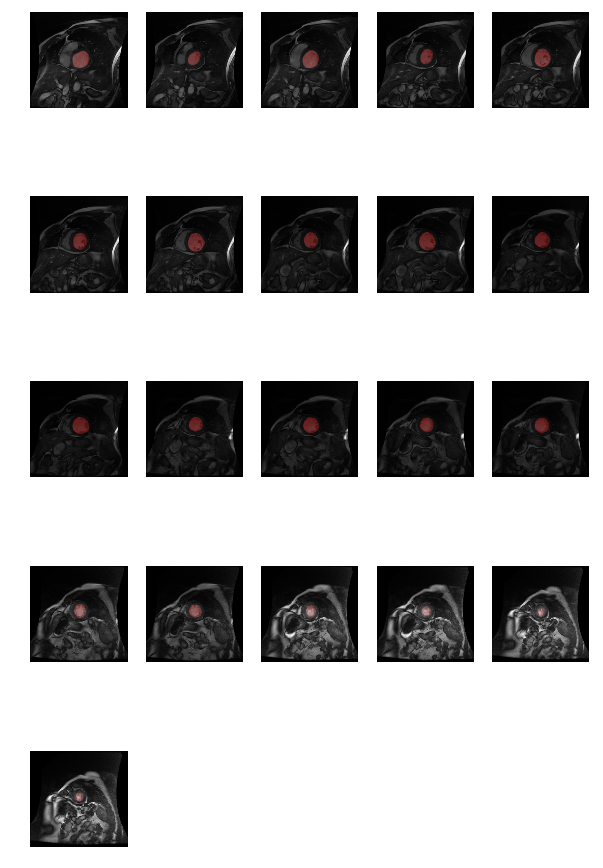

In [2]:
# Note in this phase of the challenge you will only be using the i-contours. 
# This means that every DICOM may not have a contour (and vice-versa), 
# and that some data may otherwise appear missing and/or incorrect. 
# parsing a single dicom image, single contour file, and translating a parsed contour file 
# into a boolean mask
# build a pipeline that will parse the DICOM images and i-contour contour files, 
# making sure to pair the correct DICOM image(s) with the correct contour file. 
# After parsing each i-contour file, make sure to translate the parsed contour to a boolean mask.

# set the dir paths
baseDir = '/Users/anitha/Desktop/Arterys/final_data'
try:
    ipDir = np.genfromtxt(os.path.join(baseDir,'link.csv'), delimiter=',', usecols=(0,1), dtype=str,skip_header=True)
except IOError:
    print("unable to read/find the link csv file")
    sys.exit(1)
for ind in range(len(ipDir)):
    curDcmDir = os.path.join(baseDir,'dicoms/'+ipDir[ind][0])
    curConDir = os.path.join(baseDir,'contourfiles/'+ipDir[ind][1]+"/i-contours")
    trainCSV = os.path.join(os.path.split(curConDir)[0],'imgContPair.csv')
    bDir = os.path.split(curConDir)[0]
    laneMask = genTrainPair(curDcmDir,curConDir,trainCSV)
    chkMask(curDcmDir,curConDir,bDir)

How did you verify that you are parsing the contours correctly?
I fused the dicom and boolean masks to verify if the contours are aligning with the image as shown in the cell above.

What changes did you make to the code, if any, in order to integrate it into our production code base? 
I didn't make any changes to parsing.py. I added my functions in utils.py
\1) overlayImg(dcmImg,mask,alpha=0.7): fuses the dicom grayscale and boolean masks
\2) createContMask(contFname,imSize): creates a boolean mask from the contour file and image size
\3) getNumFromDcmFname(dcmFname) & getNumFromContFname(contFname): these are functions to extract the image number from the filenames. I separated this as a function as it'll be easier to modify in the format of filename changes in the future
\4) genTrainPair(dcmDir,conDir,opFname): main function that takes dicom image and contour directory and creates a list with the pairs. 
\5) writeCSV(listVal,fName): write the csv list to file. The files are written individually per patient, which might be easily scalable and one can read a sub-set if needed.
\6) chkMask(dcmDir,conDir,opBaseDir): a debugging function to read the csv pair file, create fused images and write to an overlay folder per patient

lastIndex: 0
lastIndex: 16
lastIndex: 32
lastIndex: 48
lastIndex: 64
lastIndex: 80


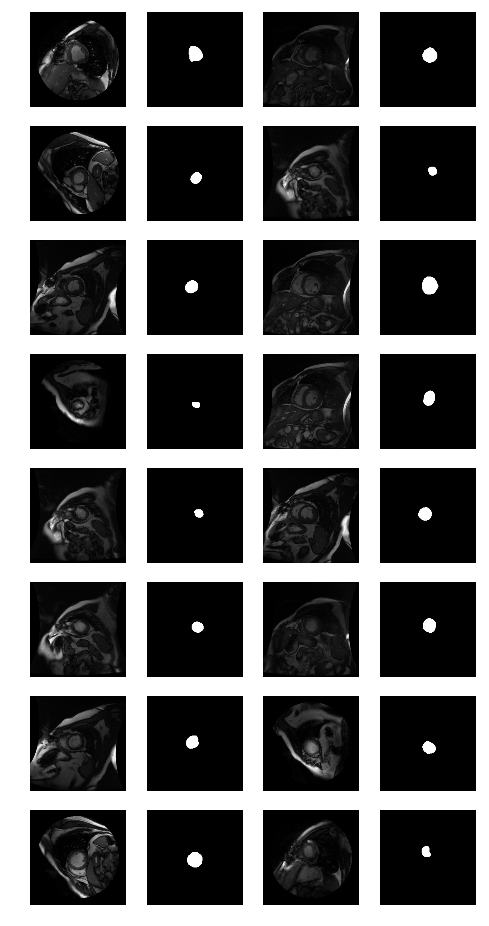

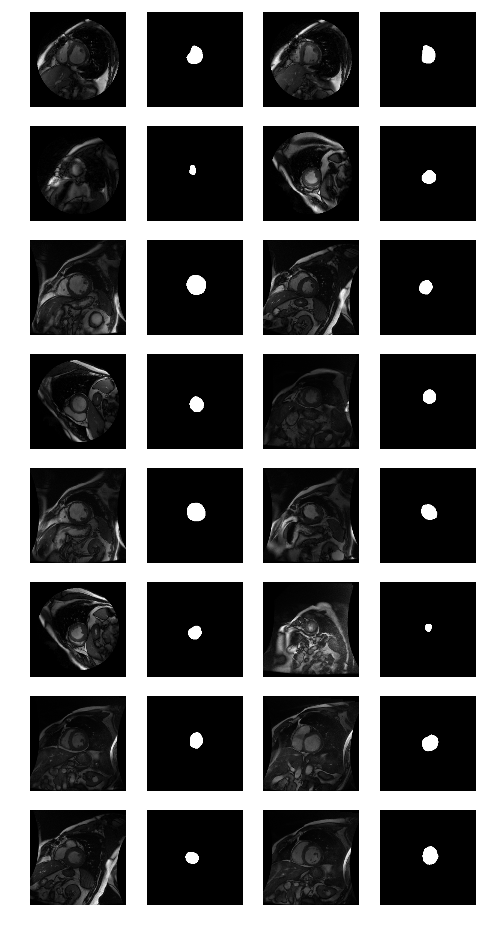

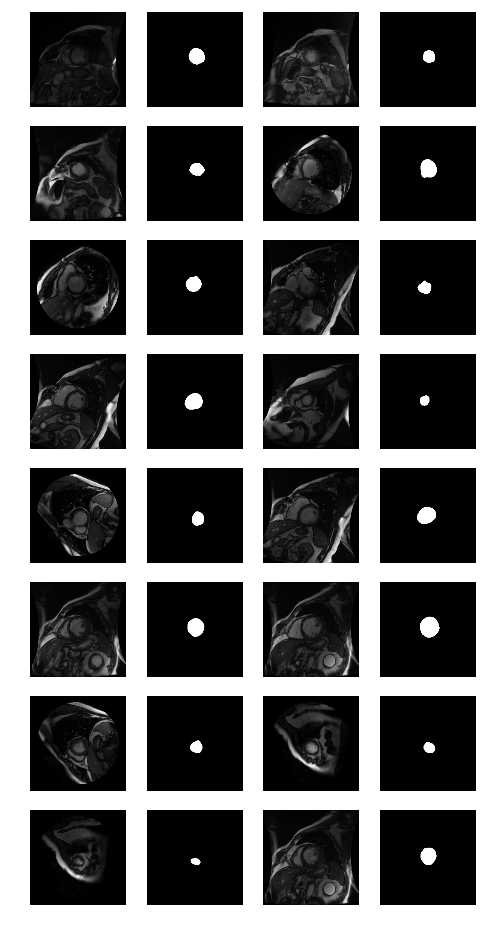

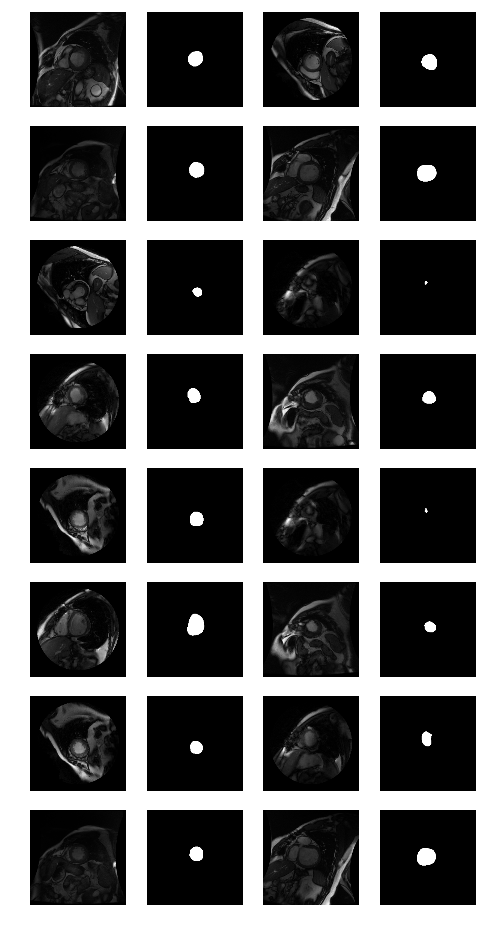

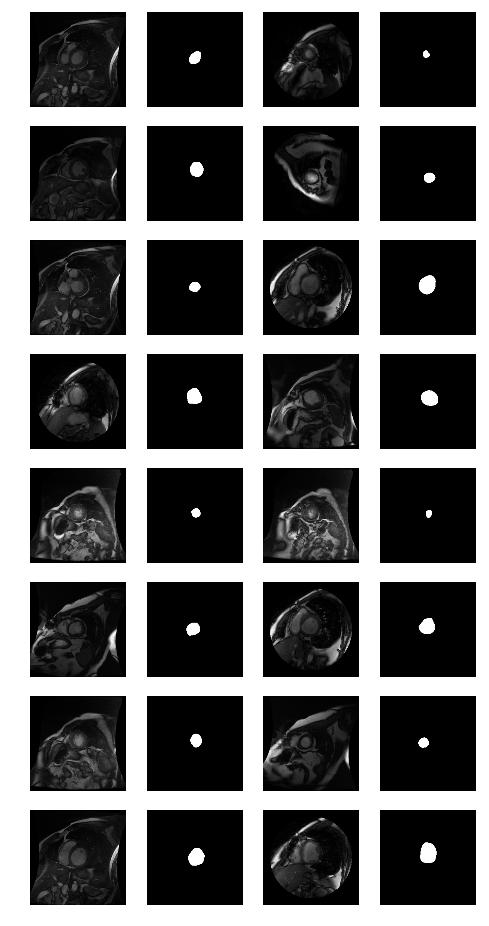

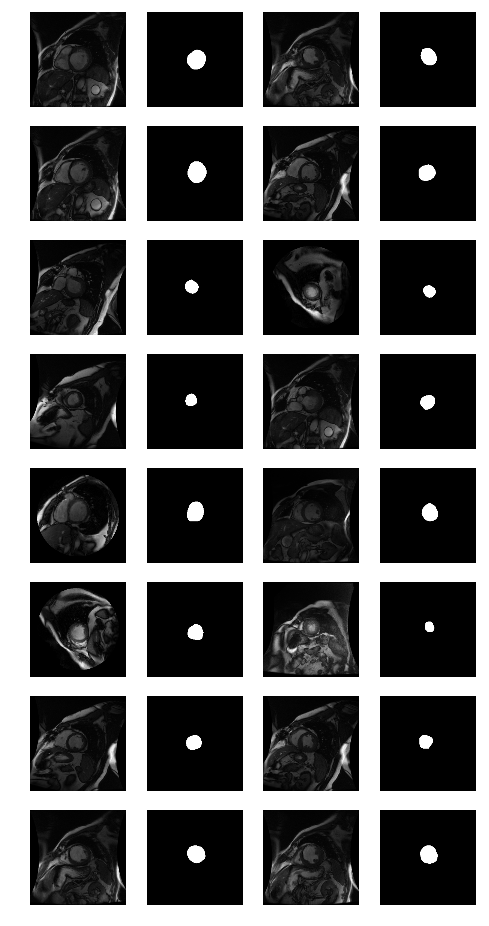

In [3]:
#Cycles over the entire dataset, loading a single batch (e.g. 8 observations) of inputs 
#(DICOM image data) and targets (boolean masks) at each training step.
#A single batch of data consists of one numpy array for images and one numpy array for targets.
# Within each epoch (e.g. iteration over all studies once), samples from a batch should be 
# loaded randomly from the entire dataset.

imgFnames = []
contFnames = []
for val in ipDir[:,1]:
    fname = os.path.join(baseDir,'contourfiles/'+val+'/imgContPair.csv')
    imgPath = np.genfromtxt(fname, delimiter=',', usecols=(0,1), dtype=str)
    imgFnames.extend(imgPath[:,0])
    contFnames.extend(imgPath[:,1])
imgFnames = np.array(imgFnames)
contFnames = np.array(contFnames)
imgFnames, contFnames = shuffle(imgFnames, contFnames, random_state=0)
batch_size=16
concatDim = 0
try1 = readTrainPair(imgFnames, contFnames,batch_size,concatDim)
for img,mask in try1:
    plt.figure(figsize=(8,16))
    n = 0
    for i in range(batch_size):
        if i==0:
            plt.subplot(8,4,i+1); plt.imshow(img[i],cmap='gray'); plt.axis('off')
            plt.subplot(8,4,i+2); plt.imshow(mask[i],cmap='gray'); plt.axis('off')
            #print([i+1,i+2])
            lInd = i+2
        else:
            plt.subplot(8,4,lInd+1); plt.imshow(img[i],cmap='gray'); plt.axis('off')
            plt.subplot(8,4,lInd+2); plt.imshow(mask[i],cmap='gray'); plt.axis('off')
            #print([lInd+1,lInd+2])
            lInd = lInd+2
        

Did you change anything from the pipelines built in Parts 1 to better streamline the pipeline built in Part 2? If so, what? If not, is there anything that you can imagine changing in the future?
I didn't change the pipeline built in part 1. I can't think of anything that I would like to change in the future.

How do you/did you verify that the pipeline was working correctly?
I ran the iterator for one epoch, got the dicom images and mask in batches of 16 and displayed it in the above cell

Given the pipeline you have built, can you see any deficiencies that you would change if you had more time? If not, can you think of any improvements/enhancements to the pipeline that you could build in?
I currently don't have any unit tests on these functions. Given more time, I would probably write some unit tests and create a logger to keep track of the errors